# Identifying model bias

In this second part we will use explanation methods to identify a faulty classifier that was trained on biased data.
Specifically, each image contains an artifact whose color is related to the class of the image.
A model trained with such images will likely learn to disregard the image content entirely and only focus on
the artifact to make a prediction.
You will use one of the explanation methods implemented in the first part to spot the issue.

Altough in this example the bias was introduced artificially, it's not uncommon to see this kind of telling artifacts
in real-world datasets. For example, in a dataset of X-ray scans, one might find identifiers along the edge or
marks left by doctors that could hinder the learning of a model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!jupyter nbconvert --to latex '/content/drive/MyDrive/Colab Notebooks/ModelBias.ipynb' --output '/content/drive/MyDrive/DL_advance/practical1/ModelBias.tex'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/ModelBias.ipynb to latex
[NbConvertApp] Writing 65226 bytes to /content/drive/MyDrive/DL_advance/practical1/ModelBias.tex


## Setup

In [ ]:
!pip install jax_resnet

In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow as tf

tf.get_logger().setLevel("WARNING")
tf.config.experimental.set_visible_devices([], "GPU")

import json
from functools import partial
from pathlib import Path

import flax
import flax.core
import jax
import jax.numpy as jnp
import jax_resnet
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import tqdm
from IPython.display import Markdown, display

## Utils

In [ ]:
CLASS_NAMES = (
    "tench",
    "English springer",
    "cassette player",
    "chain saw",
    "church",
    "French horn",
    "garbage truck",
    "gas pump",
    "golf ball",
    "parachute",
)

BIAS_COLORS = [
    [0.1215, 0.4666, 0.7058],
    [0.5490, 0.3372, 0.2941],
    [1.0000, 0.4980, 0.0549],
    [0.1725, 0.6274, 0.1725],
    [0.8392, 0.1529, 0.1568],
    [0.5803, 0.4039, 0.7411],
    [0.8901, 0.4666, 0.7607],
    [0.7372, 0.7411, 0.1333],
    [0.0901, 0.7450, 0.8117],
    [0.4980, 0.4980, 0.4980],
]

RED = np.array([1.0, 0, 0])
BLUE = np.array([0, 0, 1.0])


def create_dataset(data_dir: str, batch_size: int):
    ds_builder = tfds.builder("imagenette/320px-v2", data_dir=data_dir)
    ds_builder.download_and_prepare()

    ds_val = ds_builder.as_dataset("validation", as_supervised=True)
    ds_val = ds_val.map(resize)
    ds_val = ds_val.map(add_bias_pixel)
    ds_val = ds_val.batch(batch_size)
    ds_val = tfds.as_numpy(ds_val)

    return ds_val


def resize(image, label):
    image = tf.image.resize_with_pad(image, 224, 224)
    return image / 255.0, label


def add_bias_pixel(image, label):
    hw_ = tf.reduce_sum(image, axis=[0, 1])
    hw_ = tf.cast(hw_, tf.int32) % 30 + 140
    h = hw_[0]
    w = hw_[1]
    color = tf.constant(BIAS_COLORS)[label]
    mask = tf.meshgrid(tf.range(224), tf.range(224), indexing="ij")
    mask = (
        (mask[0] % 12 != tf.cast(label, tf.int32) + 1)
        & (mask[0] > h)
        & (mask[0] < h + 12)
        & (mask[1] % 5 < 2)
        & (mask[1] > w)
        & (mask[1] < w + 30)
    )
    image = tf.where(mask[:, :, None], color, image)
    return image, label


def load_checkpoint(path):
    @jax.jit
    def logits_fn(variables, img):
        # img: [H, W, C], float32 in range [0, 1]
        assert img.ndim == 3
        img = normalize_for_resnet(img)
        logits = model.apply(variables, img[None, ...], mutable=False)[0]
        return logits.max(), logits

    path = Path(path)
    args = json.loads(Path.read_text(path / "args.json"))
    variables_path = path / "variables.npy"


    model = getattr(jax_resnet.resnet, f"ResNet{args['resnet_size']}")(n_classes=10)
    variables = model.init(jax.random.PRNGKey(0), jnp.zeros((1, 224, 224, 3)))
    variables = flax.serialization.from_bytes(variables, variables_path.read_bytes())

    return logits_fn, variables


def normalize_for_resnet(images):
    # images: [..., H, W, 3], float32, range [0, 1]
    mean = jnp.array([0.485, 0.456, 0.406])
    std = jnp.array([0.229, 0.224, 0.225])
    return (images - mean) / std


def imagenet_to_imagenette_logits(logits):
    """Select the 10 imagenette classes from the 1000 imagenet classes."""
    return logits[..., [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]]


def show_images(images, labels=None, logits=None, ncols=4, width_one_img_inch=3.0):
    B, H, W, *_ = images.shape
    nrows = int(np.ceil(B / ncols))
    fig, axs = plt.subplots(
        nrows,
        ncols,
        figsize=width_one_img_inch * np.array([1, H / W]) * np.array([ncols, nrows]),
        sharex=True,
        sharey=True,
        squeeze=False,
        facecolor="white",
    )
    for b in range(B):
        ax = axs.flat[b]
        ax.imshow(images[b])
        if labels is not None:
            ax.set_title(CLASS_NAMES[labels[b]])
        if logits is not None:
            pred = logits[b].argmax()
            prob = jax.nn.softmax(logits[b])[pred]
            color = (
                "blue" if labels is None else ("green" if labels[b] == pred else "red")
            )
            p = mpl.patches.Patch(color=color, label=f"{prob:.2%} {CLASS_NAMES[pred]}")
            ax.legend(handles=[p])
    fig.tight_layout()
    display(fig)
    plt.close(fig)


@jax.jit
def blend(a, b, alpha: float):
    return (1 - alpha) * a + alpha * b

## Metrics

These tables summarize the hyperparameters used to train the models and their performance.

Accuracy and loss are reported for two slightly different versions of the validation set:
one that contains a clear source of bias and one that doesn't. If we only had access to
the biased dataset and we did not know about the bias, we might be tempted to choose the
first model, which achieves a much higher accuracy than the second.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
paths = [Path('/content/drive/MyDrive/DL_advance/output/biased'), Path('/content/drive/MyDrive/DL_advance/output/unbiased')]

df_args = (
    pd.DataFrame([json.loads(Path.read_text(p / "args.json")) for p in paths])
    .drop(columns="output")
    .set_index("run_id")
    .sort_index()
)
display(df_args)

df_test = pd.DataFrame(
    [
        {"run_id": p.parent.name, **json.loads(line)}
        for p in paths
        for line in Path.read_text(p / "test.json").splitlines()
    ],
)

display(
    df_test.pivot_table(
        index="run_id", columns="bias_pixel", values=["accuracy", "loss"]
    )
    .sort_index()
    .style.format("{:.3f}")
    .format("{:.1%}", subset="accuracy")
)

,bias_pixel,resnet_size,epochs,seed,learning_rate,weight_decay,batch_size
run_id,,,,,,,
biased,True,18,10,5807,0.001,0.0001,64
unbiased,False,18,10,5807,0.001,0.0001,64


## Model comparison

### Task 1

Reimplement one of the explanation methods from the previous notebook and use it to
visualize the most important regions for the first few batches of images.

- Can you spot the model that was trained on biased data?
- Which explanation method did you choose? Can you motivate your choice?
  Did you try others to see what worked best?
- Can you summarize the explanation method and suggest why it works best here?

Add your comments below:
- Model A is trained on biased data since the important spots are always near a certain place with specific color indicating to a certain class.
- I chose intergrated gradient as the explaination method since it performs the best in the previous task.
- The intergrated gradient method calculates the integral of the gradients of the model's output with respect to its inputs along a straight path from a baseline (usually the zero-input or a neutral point) to the input of interest. The resulting attribution values indicate the contribution of each feature to the model's prediction.

Note: `explanation_fn` will be called with `logits_fn`, `variables`, and `images`. Extra parameters can be put in `kwargs` and `partial` will take care of them.

In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow as tf

tf.get_logger().setLevel("WARNING")
tf.config.experimental.set_visible_devices([], "GPU")

from collections import defaultdict
from functools import partial
from typing import Sequence

import flax.core
import flax.linen as nn
import jax
import jax.numpy as jnp
import jax_resnet
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import sklearn.metrics
import tabulate
import tensorflow_datasets as tfds
import torch
import tqdm
from flax.training.train_state import TrainState
from IPython.display import display
from jax import jit, vmap

RED = np.array([1.0, 0, 0])
BLUE = np.array([0, 0, 1.0])


@jax.jit
def normalize_zero_one(x):
    """Normalize a vector between 0 and 1."""
    res = (x - x.min()) / (x.max() - x.min())
    res = jnp.clip(res, a_min=0, a_max=1)
    return res


@jax.jit
def normalize_max(x):
    """Normalize a vector between -1 and 1."""
    res = x / jnp.abs(x).max()
    res = jnp.clip(res, a_min=-1, a_max=1)
    return res


@jax.jit
def blend(a, b, alpha: float):
    """Blend two float-valued images"""
    return (1 - alpha) * a + alpha * b

In [ ]:
def grad_norm_fn(logits_fn, variables, img):
    H, W, _ = img.shape

    # TODO
    foo_vg = jax.value_and_grad(logits_fn, argnums=1, has_aux=True)
    (y_sum, logits), grad = foo_vg(variables,img)
    grad = jnp.sum(jnp.abs(grad),axis = 2)
    grad = normalize_max(grad)

    # logits: [num_classes]
    # grad:   [H, W]
    return logits, grad


grad_norm_fn = jax.jit(grad_norm_fn, static_argnames=["logits_fn"])
grad_norm_fn = jax.vmap(grad_norm_fn, in_axes=(None, None, 0))


def grad_x_input_fn(logits_fn, variables, img):
    H, W, _ = img.shape

    # TODO
    foo_vg = jax.value_and_grad(logits_fn, argnums=1, has_aux=True)
    (y_sum, logits), grad = foo_vg(variables,img)

    grad = img*grad
    grad = jnp.sum(jnp.abs(grad),axis = 2)
    grad = normalize_zero_one(grad)

    # logits: [num_classes]
    # grad:   [H, W]
    return logits, grad


grad_x_input_fn = jax.vmap(grad_x_input_fn, in_axes=(None, None, 0))
grad_x_input_fn = jax.jit(grad_x_input_fn, static_argnames=["logits_fn"])

@partial(jax.jit, static_argnames=["steps"])
def prepare_integrated_gradients(img, steps: int):
    assert img.ndim == 3
    return img[None, :, :, :] * jnp.linspace(1, 0, num=steps)[:, None, None, None]



def integrated_grad_fn(logits_fn, variables, img, steps: int):
    H, W, _ = img.shape

    # Get the index of the most confident prediction
    _, logits_orig = logits_fn(variables, img)
    probs_orig = jax.nn.softmax(logits_orig)
    idx = jnp.argmax(probs_orig)


    # Prepare a batch of progressively darker images
    images = prepare_integrated_gradients(img, steps)
    grad2 = jnp.zeros(img.shape)
    # Compute gradients for each image in the batch
    for i in range(steps):
      gradfun = jax.grad(logits_fn, argnums=1, has_aux=True)
      grad, _= gradfun(variables,images[i])
      grad2 += grad



    # Approximate the path integral using a finite sum

    attrib = img * grad2 * (1.0 / steps)
    attrib = jnp.sum(jnp.abs(attrib),axis = 2)
    attrib = normalize_zero_one(attrib)


    # logits: [num_classes]
    # grads:  [H, W]
    return logits_orig, attrib


integrated_grad_fn = jax.jit(integrated_grad_fn, static_argnames=["logits_fn", "steps"])
integrated_grad_fn = jax.vmap(integrated_grad_fn, in_axes=(None, None, 0, None))



In [ ]:
ds_val = create_dataset(".", batch_size=4)
logits_fn_a, variables_a = load_checkpoint("/content/drive/MyDrive/DL_advance/output/biased")
logits_fn_b, variables_b = load_checkpoint("/content/drive/MyDrive/DL_advance/output/unbiased")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling imagenette/320px-v2/1.0.0.incompleteXEHQ2B/imagenette-train.tfrecord*...:   0%|          | 0/9469 [0…

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling imagenette/320px-v2/1.0.0.incompleteXEHQ2B/imagenette-validation.tfrecord*...:   0%|          | 0/39…

Dataset imagenette downloaded and prepared to ./imagenette/320px-v2/1.0.0. Subsequent calls will reuse this data.


## Batch 0

### Model A

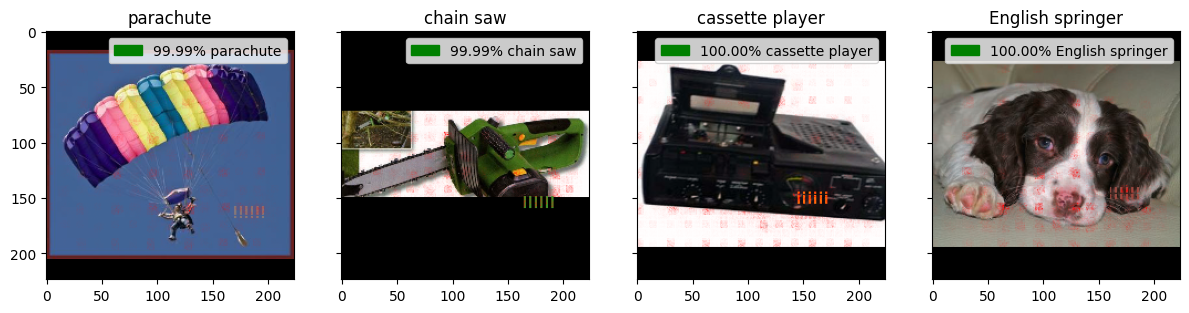

### Model B

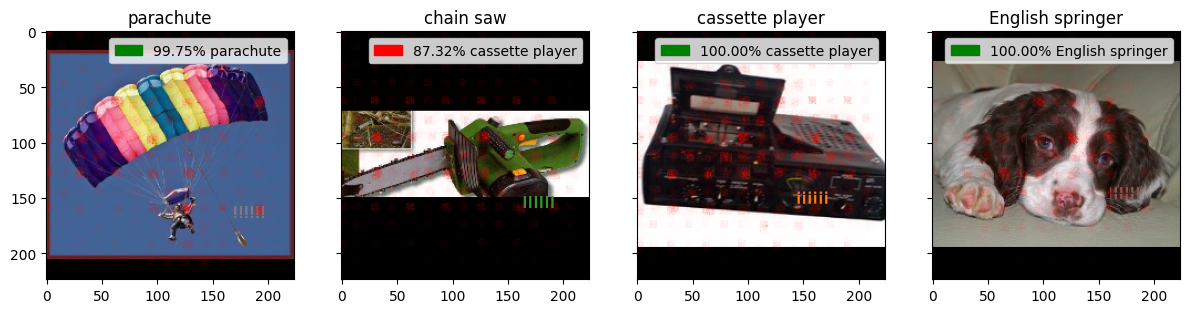

## Batch 1

### Model A

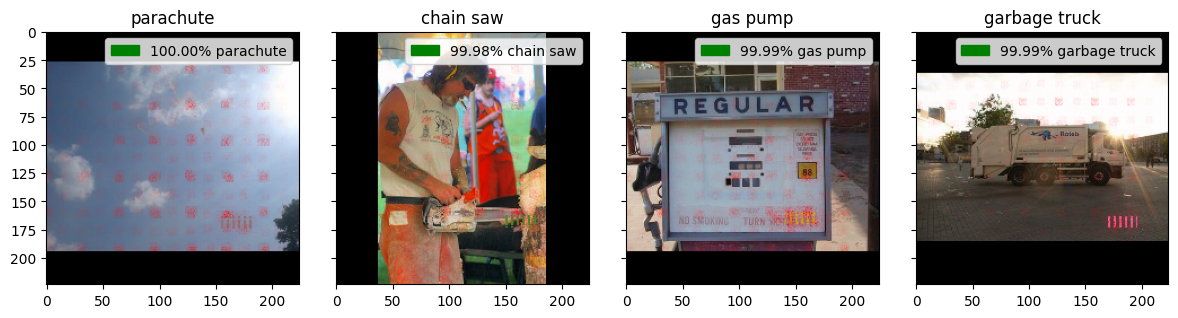

### Model B

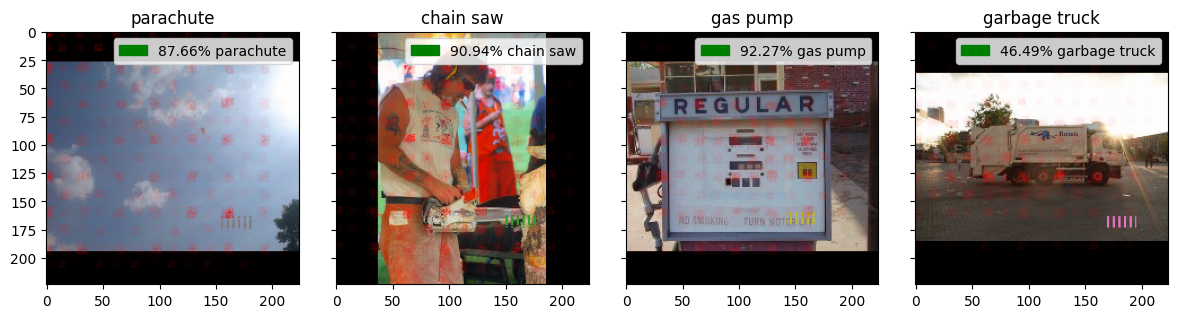

## Batch 2

### Model A

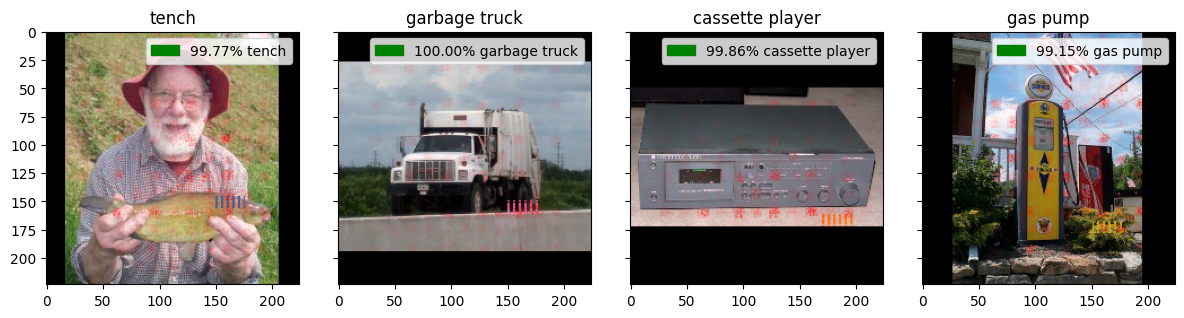

### Model B

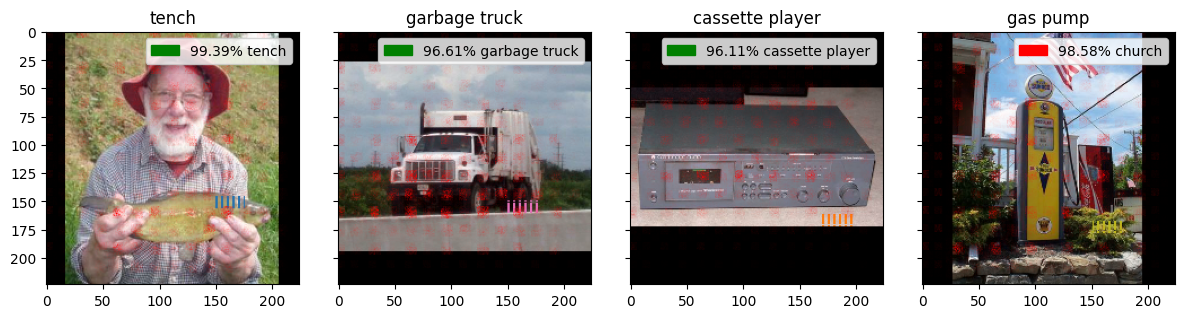

In [ ]:
for batch_idx, (images, labels) in enumerate(ds_val):
    display(Markdown(f"## Batch {batch_idx}"))

    display(Markdown(f"### Model A"))
    logits, relevance0 = integrated_grad_fn(logits_fn_a, variables_a, images, 25)

    show_images(
        blend(images, RED, relevance0.clip(min=0)[..., None]),
        labels,
        logits,
    )


    display(Markdown(f"### Model B"))
    logits, relevance1 = grad_norm_fn(logits_fn_b, variables_b, images)
    show_images(
        blend(images, RED, relevance1.clip(min=0)[..., None]),
        labels,
        logits,
    )



    if batch_idx >= 2:
        break